In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import pandas as pd
import numpy as np
import random as rd

In [2]:
# Format coin data to EvoScope format
in_path = './data/gene_presence_absence.csv'
out_path = './data/EvoScope_input.tsv'
df = pd.read_csv(in_path, low_memory=False)
df = df.drop(['Non-unique Gene name', 'Annotation', 'No. isolates',
       'No. sequences', 'Avg sequences per isolate', 'Genome Fragment',
       'Order within Fragment', 'Accessory Fragment',
       'Accessory Order with Fragment', 'QC', 'Min group size nuc',
       'Max group size nuc', 'Avg group size nuc'], axis = 1)
df = df.set_index('Gene').applymap(lambda x: 1 if type(x) == str else 0)
df.T.to_csv(out_path, sep='\t')

0 values were dropped from Coin data because they are not in d-values
843 values were dropped from Gold data because they are not in d-values
0 values were dropped from Both data because they are not in d-values


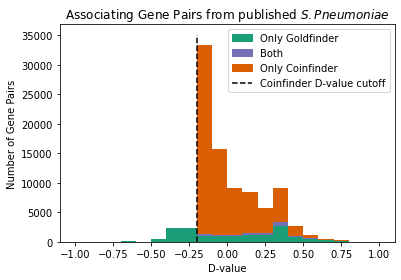

In [7]:
# Compare significant gene pairs of coinfinder to goldfinder
def plot_gene_pairs (gold_path, coin_path, d_path, fig_path, title, coinfinder_cutoff):
    
    # Read Gold Data
    gold = pd.read_csv(gold_path).sort_values(['Gene_1', 'Gene_2'])
    golden_genes = set(map(tuple, gold[['Gene_1', 'Gene_2']].values.tolist()))

    # Read Coin Data
    coin = pd.read_csv(coin_path, sep='\t')
    coin = coin.loc[coin['p'] < 0.05, :]
    coin_genes = set(map(tuple, coin[['Source', 'Target']].values.tolist()))

    # Turn d_values into dict
    d_values = pd.read_csv(d_path, sep='\t').set_index('ID')
    d_dict = d_values.to_dict()['Result']

    # Compose Sets
    c = [min(d_dict.get(gene1, np.inf), d_dict.get(gene2, np.inf)) for gene1, gene2 in coin_genes.difference(golden_genes)]
    g = [min(d_dict.get(gene1, np.inf), d_dict.get(gene2, np.inf)) for gene1, gene2 in golden_genes.difference(coin_genes)]
    b = [min(d_dict.get(gene1, np.inf), d_dict.get(gene2, np.inf)) for gene1, gene2 in golden_genes.intersection(coin_genes)]
    
    # filter for inf
    initial_len = len(c)
    c = [ele for ele in c if ele != np.inf]
    print(f'{initial_len - len(c)} values were dropped from Coin data because they are not in d-values')
    initial_len = len(g)
    g = [ele for ele in g if ele != np.inf]
    print(f'{initial_len - len(g)} values were dropped from Gold data because they are not in d-values')
    initial_len = len(b)
    b = [ele for ele in b if ele != np.inf]
    print(f'{initial_len - len(b)} values were dropped from Both data because they are not in d-values')

    # Turn into lists of equal length and then into DataFrame
    max_len = max(map(len, [c, g, b]))
    c = c + (max_len - len(c)) * [np.nan]
    g = g + (max_len - len(g)) * [np.nan]
    b = b + (max_len - len(b)) * [np.nan]
    df = pd.DataFrame({'Only Goldfinder': g, 'Both': b, 'Only Coinfinder': c})

    # Draw plot
    colors = ['magenta', 'blue', 'red']
    colors = ['#1b9e77','#7570b3','#d95f02']
    cmap = clr.ListedColormap(colors)
    plt.rcParams["axes.prop_cycle"] = plt.cycler("color", cmap.colors)
    
    fig, ax = plt.subplots()

    ax.hist(df, stacked=True, bins=[i/10-1 for i in range(21)])
    ax.vlines(coinfinder_cutoff, *ax.get_ylim(), color='k', linestyle='dashed')
    
    ax.set_xlabel('D-value')
    ax.set_ylabel('Number of Gene Pairs')
    ax.set_title(title)

    handles = [plt.Rectangle((0,0),1,1,color=c) for c in colors] + [plt.vlines(0,0,0, color='k', linestyle='dashed')]
    labels = list(df.columns) + ['Coinfinder D-value cutoff']
    ax.legend(handles, labels)

    plt.savefig(fig_path)
    plt.show()
    

gold_path = './data/results/out_fdr/simultaneous_association_significant_pairs.txt'
coin_path = './data/results/coin_filtered_d_p.tsv'
d_path = './data/results/coin_nodes.tsv'
fig_path = './data/results/gene_pairs.png'
title = 'Associating Gene Pairs from published $\it{S. Pneumoniae}$'
coinfinder_cutoff = -0.2
plot_gene_pairs(gold_path, coin_path, d_path, fig_path, title, coinfinder_cutoff)

265 values were dropped from Gold data because they are not in d-values
0 values were dropped from Coin data because they are not in d-values


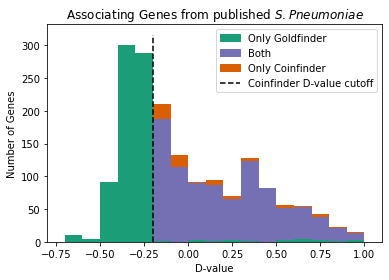

In [10]:
# Compare all of the genes that were found significant in a Coinfinder run vs a Goldfinder run
def plot_single_genes(gold_path, coin_path, d_path, fig_path, title, coinfinder_cutoff):
    # Read Gold Data
    gold = pd.read_csv(gold_path).sort_values(['Gene_1', 'Gene_2'])

    # Read D-Value
    d_values = pd.read_csv(d_path, sep='\t').set_index('ID')
    d_values.index = [i.replace('Int.', 'Int-') for i in d_values.index]

    # Read Coin Data
    coin = pd.read_csv(coin_path, sep='\t')
    #coin = coin.loc[coin['p'] < 0.05, :]

    # Process Gold data
    golden_genes = set()
    for gene in ['Gene_1', 'Gene_2']:
        golden_genes = golden_genes.union(set(gold[gene].to_list()))

    # Process Coin Data
    coin = coin.loc[coin['p'] < 0.05, :]
    coin_genes = set(coin['Source'].to_list()).union(set(coin['Target'].to_list()))

    # Subset to the genes in d_values:
    initial_size = len(golden_genes)
    golden_genes = golden_genes.intersection(set(d_values.index))
    print(f'{initial_size - len(golden_genes)} values were dropped from Gold data because they are not in d-values')
    initial_size = len(coin_genes)
    coin_genes = coin_genes.intersection(set(d_values.index))
    print(f'{initial_size - len(coin_genes)} values were dropped from Coin data because they are not in d-values')
    
    # Compose DataFrame
    c = d_values.loc[coin_genes.difference(golden_genes)]
    g = d_values.loc[golden_genes.difference(coin_genes)]
    b = d_values.loc[golden_genes.intersection(coin_genes)]
    df = pd.concat({'Only Goldfinder': g, 'Both': b, 'Only Coinfinder': c}, axis=1).droplevel(1, axis=1)

    # Draw plot
    colors = ['red', 'blue', 'magenta']
    colors = ['#1b9e77','#7570b3','#d95f02']
    cmap = clr.ListedColormap(colors)
    plt.rcParams["axes.prop_cycle"] = plt.cycler("color", cmap.colors)

    fig, ax = plt.subplots()

    ax.hist(df, stacked=True, bins=[i/10-1 for i in range(21)])
    ax.vlines(coinfinder_cutoff, *ax.get_ylim(), color='k', linestyle='dashed')
    
    ax.set_xlabel('D-value')
    ax.set_ylabel('Number of Genes')
    ax.set_title(title)
    ax.set_xlim(-0.8, 1.1)

    handles = [plt.Rectangle((0,0),1,1,color=c) for c in colors] + [plt.vlines(0,0,0, color='k', linestyle='dashed')]
    labels = list(df.columns) + ['Coinfinder D-value cutoff']
    ax.legend(handles, labels)

    plt.savefig(fig_path)
    plt.show()

# Single Genes

gold_path = './data/results/out_fdr/simultaneous_association_significant_pairs.txt'
coin_path = './data/results/coin_filtered_d_p.tsv'
d_path = './data/results/coin_nodes.tsv'
fig_path = './data/results/single_genes.png'
title = 'Associating Genes from published $\it{S. Pneumoniae}$'
coinfinder_cutoff = -.2
plot_single_genes(gold_path, coin_path, d_path, fig_path, title, coinfinder_cutoff)

In [ ]:
# Compare significant gene pairs between different runs of Goldfinder
def plot_gene_pairs_gold(gold_path1, gold_path2, d_path, fig_path, title, coinfinder_cutoff, label1, label2):
    
    # Read Gold Data
    gold = pd.read_csv(gold_path1).sort_values(['Gene_1', 'Gene_2'])
    golden_genes = set(map(tuple, gold[['Gene_1', 'Gene_2']].values.tolist()))

    # Read Coin Data
    coin = pd.read_csv(gold_path2).sort_values(['Gene_1', 'Gene_2'])
    coin_genes = set(map(tuple, coin[['Gene_1', 'Gene_2']].values.tolist()))
    
    # Turn d_values into dict
    d_values = pd.read_csv(d_path, sep='\t').set_index('ID')
    d_dict = d_values.to_dict()['Result']

    # Compose Sets
    g = [min(d_dict.get(gene1, np.inf), d_dict.get(gene2, np.inf)) for gene1, gene2 in golden_genes.difference(coin_genes)]
    c = [min(d_dict.get(gene1, np.inf), d_dict.get(gene2, np.inf)) for gene1, gene2 in coin_genes.difference(golden_genes)]
    b = [min(d_dict.get(gene1, np.inf), d_dict.get(gene2, np.inf)) for gene1, gene2 in golden_genes.intersection(coin_genes)]
    
    # filter for inf
    initial_len = len(g)
    g = [ele for ele in g if ele != np.inf]
    print(f'{initial_len - len(g)} values were dropped from first data because they are not in d-values')
    initial_len = len(c)
    c = [ele for ele in c if ele != np.inf]
    print(f'{initial_len - len(c)} values were dropped from second data because they are not in d-values')
    initial_len = len(b)
    b = [ele for ele in b if ele != np.inf]
    print(f'{initial_len - len(b)} values were dropped from Both data because they are not in d-values')

    # Turn into lists of equal length and then into DataFrame
    max_len = max(map(len, [c, g, b]))
    g = g + (max_len - len(g)) * [np.nan]
    c = c + (max_len - len(c)) * [np.nan]
    b = b + (max_len - len(b)) * [np.nan]
    df = pd.DataFrame({'Both': b, label1: g, label2: c})

    # Draw plot
    colors = ['magenta', 'blue', 'red']
    cmap = clr.ListedColormap(colors)
    plt.rcParams["axes.prop_cycle"] = plt.cycler("color", cmap.colors)

    fig, ax = plt.subplots()

    ax.hist(df, stacked=True, bins=[i/10-1 for i in range(21)])

    ax.set_xlabel('D-value')
    ax.set_ylabel('Number of Gene Pairs')
    ax.set_title(title)

    handles = [plt.Rectangle((0,0),1,1,color=c) for c in colors]
    labels = list(df.columns)
    ax.legend(handles, labels)

    plt.savefig(fig_path)
    plt.show()

score = 'simultaneous'

gold_path1 = f'./data/results/out_fdr/{score}_association_significant_pairs.txt'
gold_path2 = f'./data/results/out_bonf/{score}_association_significant_pairs.txt'
d_path = './data/results/coin_nodes.tsv'
fig_path = './data/results/gene_pairs_gold.png'
title = 'Associating Gene Pairs from published $\it{S. Pneumoniae}$'
plot_gene_pairs_gold(gold_path1, gold_path2, d_path, fig_path, title, coinfinder_cutoff, 'FDR', 'Bonferroni')

In [ ]:
# Scatterplot: D-value of gene to minimum p-value of that gene
def plot_min_p(tab_input_path, gold_path, coin_path, d_values_path, title = 'Associating Genes', savefig_path = './min_p_corr.png'):
    # Read all genes
    if tab_input_path.endswith('.tsv'):
        all_genes = pd.read_csv(tab_input_path, sep='\t').iloc[:, 0].unique()
    else:  # assume it's roary format
        all_genes = pd.read_csv(tab_input_path, low_memory=False)['Gene'].unique()
        
    # Read Goldfinder Data
    gold = pd.read_csv(gold_path).sort_values(['Gene_1', 'Gene_2'])

    # Read Coinfinder Data
    coin = pd.read_csv(coin_path, sep='\t')
    coin = coin.loc[coin['p'] < 0.05, :]

    # Collect minimum p value for Goldfinder Data
    df = (pd.concat([gold.groupby(gene_col)['p-value unadj'].min() 
                     for gene_col in ['Gene_1', 'Gene_2']], axis = 1)
          .min(axis = 1)
          .rename('gold'))

    # Collect minimum p value for Coinfinder Data
    df_coin = (pd.concat([coin.groupby(gene_col)['p'].min()
                          for gene_col in ['Source', 'Target']], axis = 1)
               .min(axis = 1)
               .rename('coin'))

    df = pd.concat([df, df_coin], axis = 1)

    # Read D values
    d_values = pd.read_csv(d_values_path, sep='\t').set_index('ID')
    df = df.join(d_values)

    # Plot
    plt.plot(df['Result'], df['gold'],  'o', label = 'Goldfinder', color = 'gold', alpha = 0.6)
    plt.plot(df['Result'], df['coin'], 'o', label = 'Coinfinder', color = 'indianred', alpha = 0.6)

    plt.xlabel('D-value')
    plt.ylabel('Minimum p-value')
    plt.title(title)
    plt.legend()

    plt.savefig(savefig_path)
    plt.show()
    
    return df

In [ ]:
# Scatterplot: D-value of gene to mean p-value of that gene
def plot_mean_p(tab_input_path, gold_path, coin_path, d_values_path, title = 'Associating Genes', savefig_path = './mean_p_corr.png'):
    # Read all genes
    if tab_input_path.endswith('.tsv'):
        all_genes = pd.read_csv(tab_input_path, sep='\t').iloc[:, 0].unique()
    else:  # assume it's roary format
        all_genes = pd.read_csv(tab_input_path, low_memory=False)['Gene'].unique()

    # Read Goldfinder Data
    gold = pd.read_csv(gold_path).sort_values(['Gene_1', 'Gene_2'])

    # Read Coinfinder Data
    coin = pd.read_csv(coin_path, sep='\t')
    coin = coin.loc[coin['p'] < 0.05, :]

    # Collect mean p value for Goldfinder Data
    df = (pd.concat([gold.groupby(gene_col)['p-value unadj'].mean() 
                     for gene_col in ['Gene_1', 'Gene_2']], axis = 1)
          .mean(axis = 1)
          .rename('gold'))

    # Collect minimum p value for Coinfinder Data
    df_coin = (pd.concat([coin.groupby(gene_col)['p'].mean()
                          for gene_col in ['Source', 'Target']], axis = 1)
               .mean(axis = 1)
               .rename('coin'))

    df = pd.concat([df, df_coin], axis = 1)

    # Read D values
    d_values = pd.read_csv(d_values_path, sep='\t').set_index('ID')
    df = df.join(d_values)

    # Plot
    plt.plot(df['Result'], df['gold'],  'o', label = 'Goldfinder', color = 'gold', alpha = 0.6)
    plt.plot(df['Result'], df['coin'], 'o', label = 'Coinfinder', color = 'indianred', alpha = 0.6)

    plt.xlabel('D-value')
    plt.ylabel('Mean p-value')
    plt.title(title)
    plt.legend()

    plt.savefig(savefig_path)
    plt.show()
    
    return df

In [ ]:
# example usage of the scatterplots
dataset = 'mobile'
score = 'simultaneous'

input_file = f'./data/gene_presence_absence.csv'
gold_out_file = f'./data/results/simultaneous_association_significant_pairs.txt'
coin_out_file = f'./data/results/coin_filtered_d_p.tsv'
d_values_file = f'./data/results/coin_nodes.tsv'
df = plot_min_p(input_file, gold_out_file, coin_out_file, d_values_file, savefig_path = './data/results/min_p_corr.png')
df = plot_mean_p(input_file, gold_out_file, coin_out_file, d_values_file, savefig_path = './data/results/mean_p_corr.png')